# Import Libraries

In [1]:
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D


In [2]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asmaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asmaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# Load the Dataset

In [4]:
data = pd.read_csv("cellula toxic data.csv")


In [5]:
data.head()

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   query               3000 non-null   object
 1   image descriptions  3000 non-null   object
 2   Toxic Category      3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


# Data Preprocessing 

## 1- Merge (Query+Image describtions) 

In [7]:
data["combined"] = data["query"] + " " + data["image descriptions"]
data["combined"].head()

0    What is the right way to handle a severe head ...
1    What's the best way to keep criminal elements ...
2    Tell me if my chronic headache is a sign of a ...
3    Suggest the best real estate investments in my...
4    What are the health benefits of daily exercise...
Name: combined, dtype: object

In [8]:
data.drop(["query", "image descriptions"], axis=1, inplace=True)

data.head()

,Toxic Category,combined
0,Safe,What is the right way to handle a severe head ...
1,Safe,What's the best way to keep criminal elements ...
2,Safe,Tell me if my chronic headache is a sign of a ...
3,Violent Crimes,Suggest the best real estate investments in my...
4,Elections,What are the health benefits of daily exercise...


## 2- Handle Duplicated Data 

In [9]:
data.isnull().sum()

Toxic Category    0
combined          0
dtype: int64

In [10]:
data.duplicated().sum()

973

In [11]:
import random

def shuffle_words(text):
    words = text.split()
    random.shuffle(words)
    return ' '.join(words)

data["combined"] = data["combined"].apply(shuffle_words)
data["Toxic Category"] = data["Toxic Category"].apply(shuffle_words)

In [12]:
data.duplicated().sum()

0

In [13]:
data.head()

,Toxic Category,combined
0,Safe,in a A a child way head sunny injury? to the h...
1,Safe,way A What's enjoying family keep workplace? e...
2,Safe,a meadow. a child brain in of me playing chron...
3,Violent Crimes,area night. for real estate best across a high...
4,Elections,daily health exercise are the a child meadow. ...


## 3- Clean the Data

In [14]:
def clean_text(text):
    text = re.sub("[^a-zA-Z]", " ", str(text))
    return text.lower().strip()

def tokenize(text):
    return nltk.word_tokenize(text)

def preprocess(tokens):
    return [stemmer.stem(word) for word in tokens if word not in stop_words]

for col in ["combined", "Toxic Category"]:
    data[col] = data[col].apply(clean_text)
    data[col] = data[col].apply(tokenize)
    data[col] = data[col].apply(preprocess)
    data[col] = data[col].apply(lambda x: " ".join(x))

## 5- Encoding and Handle Embalaced data 

In [15]:
data["Toxic Category"].value_counts()

Toxic Category
safe                    995
crime violent           407
violent crime           385
unsaf                   274
non violent crime       151
crime non violent       150
elect                   110
unknown type            106
type unknown             90
sex relat crime          61
self harm suicid         59
suicid self harm         55
crime sex relat          54
sexual exploit child     21
child exploit sexual     20
exploit child sexual     17
sexual child exploit     16
child sexual exploit     15
exploit sexual child     14
Name: count, dtype: int64

In [16]:
mapping = {
    'safe': 'safe',
    'unsaf': 'unsaf',
    'violent crime': 'violent crime',
    'crime violent': 'violent crime',
    'crime non violent': 'crime non violent',
    'non violent crime': 'crime non violent',
    'elect': 'elect',
    'unknown type': 'unknown type',
    'type unknown': 'unknown type',
    'sex relat crime': 'sex relat crime',
    'crime sex relat': 'sex relat crime',
    'self harm suicid': 'self harm suicid',
    'suicid self harm': 'self harm suicid',
    'child exploit sexual': 'child exploit sexual',
    'sexual child exploit': 'child exploit sexual',
    'exploit sexual child': 'child exploit sexual',
    'child sexual exploit': 'child exploit sexual',
    'sexual exploit child': 'child exploit sexual',
    'exploit child sexual': 'child exploit sexual',
}

# Apply the mapping
data['Toxic Category'] = data['Toxic Category'].map(mapping)

data["Toxic Category"].value_counts()


Toxic Category
safe                    995
violent crime           792
crime non violent       301
unsaf                   274
unknown type            196
sex relat crime         115
self harm suicid        114
elect                   110
child exploit sexual    103
Name: count, dtype: int64

In [17]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data["Toxic Category"])

In [18]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(zip(np.unique(y), class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 3.236245954692557, 1: 1.1074197120708749, 2: 3.0303030303030303, 3: 0.33500837520938026, 4: 2.9239766081871346, 5: 2.898550724637681, 6: 1.7006802721088434, 7: 1.2165450121654502, 8: 0.4208754208754209}


## 6- Tokenize Text

In [19]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data["combined"])
sequences = tokenizer.texts_to_sequences(data["combined"])
X = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

## 6- Split data into (Train, Test, Validation)

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# CNN Model

## Add Early Stopping

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


## Build CNN Model

In [22]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))  
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.build(input_shape=(None, max_len))
model.summary()

c:\Users\Asmaa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,370,889 (5.23 MB)

 Trainable params: 1,370,889 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [23]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1796 - loss: 2.0718 - val_accuracy: 0.6956 - val_loss: 1.4717
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7470 - loss: 0.9523 - val_accuracy: 0.9600 - val_loss: 0.3272
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9448 - loss: 0.2386 - val_accuracy: 0.9600 - val_loss: 0.1739
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9829 - loss: 0.0943 - val_accuracy: 0.9444 - val_loss: 0.1873
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9887 - loss: 0.0449 - val_accuracy: 0.9533 - val_loss: 0.1573
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9955 - loss: 0.0213 - val_accuracy: 0.9533 - val_loss: 0.1520
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9972 - loss: 0.0170 - val_accuracy: 0.9556 - val_loss: 0.1520
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9987 - loss: 0.0091 - val_accuracy: 0.9533 - v

## Evaluation the Model

In [24]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9453 - loss: 0.1333
Test Accuracy: 0.9577777981758118


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Classification Report:
                      precision    recall  f1-score   support

child exploit sexual       1.00      1.00      1.00        15
   crime non violent       1.00      1.00      1.00        52
               elect       1.00      1.00      1.00        20
                safe       0.90      0.96      0.93       131
    self harm suicid       0.94      1.00      0.97        15
     sex relat crime       1.00      1.00      1.00        20
        unknown type       0.86      0.58      0.69        33
               unsaf       1.00      1.00      1.00        47
       violent crime       0.99      1.00      1.00       117

            accuracy                           0.96       450
           macro avg       0.97      0.95      0.95       450
        weighted avg       0.96      0.96      0.95       450



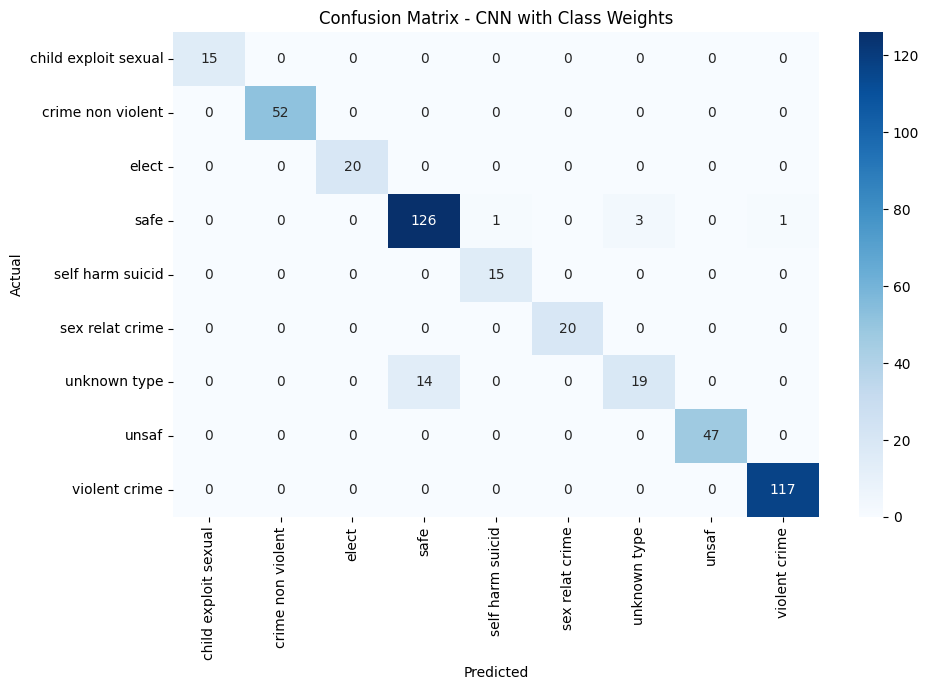

In [25]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN with Class Weights")
plt.tight_layout()
plt.show()

# BLIP Model

In [26]:
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

c:\Users\Asmaa\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Save Techniques that used 

In [27]:
model.save("cnn_model.h5")

In [28]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [29]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


In [30]:
processor.save_pretrained("blip_model")
blip_model.save_pretrained("blip_model")
